In [186]:
import umap
import numbers
import hdbscan
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

np.random.seed(42)

In [2]:
df = pd.read_csv('./GSE150150_raw_counts.csv')

# Preprocessing Data

In [3]:
columns = ["Trunk E9.5", "Trunk E10.5", "DRG E9.5", "DRG E10.5", "DRG E11.5", "DRG E12.5", "Cranio E12.5"]
idMappings = {
    "SS2_15_0085": "Trunk E9.5",
    "SS2_18_107": "Trunk E10.5",
    "SS2_18_108": "Trunk E10.5",
    "SS2_18_109": "Trunk E10.5",
    "SS2_16_767": "DRG E9.5",
    "SS2_17_435": "DRG E9.5",
    "SS2_16_688": "DRG E10.5",
    "SS2_16_769": "DRG E10.5",
    "SS2_17_432": "DRG E10.5",
    "SS2_17_433": "DRG E10.5",
    "SS2_16_385": "DRG E11.5",
    "SS2_16_384": "DRG E12.5",
    "SS2_15_0073": "Cranio E12.5",
    "SS2_15_0169": "Cranio E12.5"
}

In [4]:
df.columns = [idMappings[col.split(":")[0]] if col.split(":")[0] in idMappings else col for col in df.columns]
dfParsed = df.groupby(df.columns, axis=1).apply(lambda x: x.mean(axis=1) if isinstance(x.iloc[0,0], numbers.Number) else x.iloc[:,0])
dfParsed = dfParsed[dfParsed.columns[5:].tolist() + dfParsed.columns[:5].tolist()]

print("Grouped Gene Count: ", len(dfParsed))
sampleRow = dfParsed.sample()
print("Grouped Sample Row: ", sampleRow)
print("Grouped Sample Gene: ", sampleRow.iloc[0,0])

Grouped Gene Count:  24582
Grouped Sample Row:          Gene  Trunk E10.5  Trunk E9.5  Cranio E12.5  DRG E10.5  DRG E11.5  \
2350  Hoxd12     3.263021         0.0           0.0   0.002604        0.0   

      DRG E12.5  DRG E9.5  
2350   0.046875  0.010417  
Grouped Sample Gene:  Hoxd12


In [5]:
X = dfParsed.iloc[:,1:].values
counts = X

In [6]:
scaled_data = StandardScaler().fit_transform(counts)

In [12]:
log_data = np.log10(counts, where=counts>0)
log_array = np.array(log_data)

# t-SNE

In [8]:
tsne = TSNE(n_components=2, perplexity = 40, random_state=0, learning_rate='auto', init='pca')

In [9]:
scaled_tsne = tsne.fit_transform(scaled_data)

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


Text(0.5, 1.0, 't-SNE for Scaled Data')

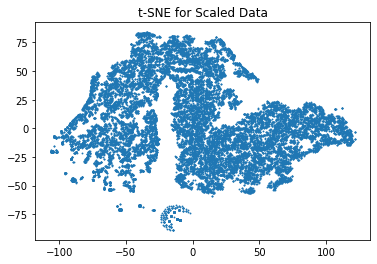

In [10]:
plt.scatter(scaled_tsne[:, 0], scaled_tsne[:, 1], s=0.75)
plt.title("t-SNE for Scaled Data")

In [13]:
log_tsne = tsne.fit_transform(log_array)

C:\Users\Jonathan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


Text(0.5, 1.0, 't-SNE for Log Transformation')

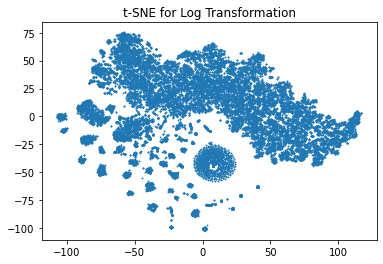

In [14]:
plt.scatter(log_tsne[:, 0], log_tsne[:, 1], s=0.75)
plt.title("t-SNE for Log Transformation")

# UMAP

In [15]:
umapper = umap.UMAP(n_neighbors=30, min_dist=0.3, metric='correlation', random_state=42)

In [16]:
count_umap = umapper.fit_transform(counts)

Text(0.5, 1.0, 'UMAP for Counts')

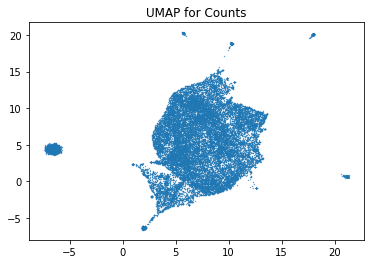

In [17]:
plt.scatter(count_umap[:, 0], count_umap[:, 1], s=0.1)
plt.title("UMAP for Counts")

In [18]:
scaled_umap = umapper.fit_transform(scaled_data)

Text(0.5, 1.0, 'UMAP for Scaled Data')

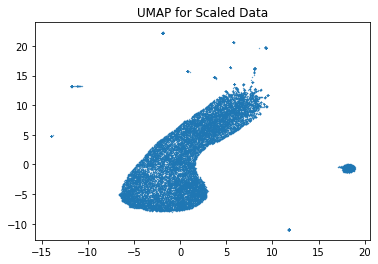

In [19]:
plt.scatter(scaled_umap[:, 0], scaled_umap[:, 1], s=0.1)
plt.title("UMAP for Scaled Data")

In [20]:
log_umap = umapper.fit_transform(log_array)

Text(0.5, 1.0, 'UMAP for Log Transformation')

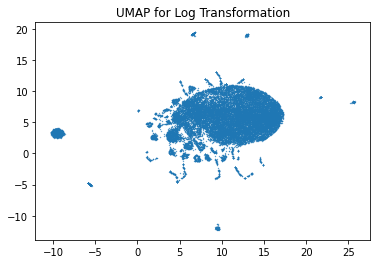

In [21]:
plt.scatter(log_umap[:, 0], log_umap[:, 1], s=0.1)
plt.title("UMAP for Log Transformation")

# HDBScan

In [132]:
hdbscandf = pd.DataFrame(log_tsne, columns = ['axis-1', 'axis-2'])

In [79]:
logging.captureWarnings(True)

In [140]:
hdb = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(hdbscandf)

param_dist = {'min_samples': [4,8,10,12,15],
              'min_cluster_size':[50,70,85,100,120],  
              'cluster_selection_method' : ['eom','leaf'],
             }

validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)

n_iter_search = 20
random_search = RandomizedSearchCV(hdb
                                   ,param_distributions=param_dist
                                   ,n_iter=n_iter_search
                                   ,scoring=validity_scorer 
                                   ,random_state=42)

random_search.fit(hdbscandf)

print(f"Best Parameters {random_search.best_params_}")
print(f"DBCV score :{random_search.best_estimator_.relative_validity_}")

Best Parameters {'min_samples': 12, 'min_cluster_size': 85, 'cluster_selection_method': 'eom'}
DBCV score :0.07643875144220096


In [189]:
cluster = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=5, gen_min_span_tree=True)
cluster.fit(hdbscandf)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=50, min_samples=5)

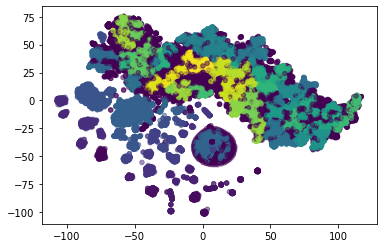

In [190]:
palette = sns.color_palette()
plt.scatter(log_tsne.T[0], log_tsne.T[1], c=cluster.labels_, alpha=0.5, s=20)

In [191]:
Nociception = ["Ntrk1", "Runx1", "Prdm12", "Th", "Scn10a", "Syt13", "Stra6", "Gal", "Prdm8"]
Mechanoreception = ["Pdlim1","Mmd2", "Pou4f3", "Rnf144a", "Pou6f2", "Dio3", "Onecut3", "Tbx2", "Gpx3", "Ret"]
Mechanoreception1 = ["Pdlim1","Mmd2", "Pou4f3", "Rnf144a"]
Mechanoreception2 = ["Pou6f2", "Dio3", "Onecut3", "Tbx2", "Gpx3", "Ret"]
Proprioception = ["Ntrk3", "Runx3", "Mgst3", "Fam19a4", "Pcp4", "Grm3"]
Fate1 = ["Runx3", "Nfia"]
Fate2 = ["Pou6f2", "Nr5a2", "Hoxb5", "Pdlim1", "Egr1"]
Fate3 = ["Tcf15", "Pdlim1"]
Fate4 = ["Pou6f2", "Onecut3", "Dcc"]

NociceptionCluster = []
MechanoreceptionCluster = []
Mechanoreception1Cluster = []
Mechanoreception2Cluster = []
ProprioceptionCluster = []
Fate1Cluster = []
Fate2Cluster = []
Fate3Cluster = []
Fate4Cluster = []

for gene in Nociception:
    NociceptionCluster.append(cluster.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Mechanoreception:
    MechanoreceptionCluster.append(cluster.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Mechanoreception1:
    Mechanoreception1Cluster.append(cluster.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Mechanoreception2:
    Mechanoreception2Cluster.append(cluster.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Proprioception:
    ProprioceptionCluster.append(cluster.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Fate1:
    Fate1Cluster.append(cluster.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Fate2:
    Fate2Cluster.append(cluster.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])
    
for gene in Fate3:
    Fate3Cluster.append(cluster.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])

for gene in Fate4:
    Fate4Cluster.append(cluster.labels_[dfParsed[dfParsed["Gene"] == gene].index[0]])


print("Nociception Cluster: ", NociceptionCluster)
print("Mechanoreception Cluster: ", MechanoreceptionCluster)
print("Mechanoreception1 Cluster: ", Mechanoreception1Cluster)
print("Mechanoreception2 Cluster: ", Mechanoreception2Cluster)
print("Proprioception Cluster: ", ProprioceptionCluster)
print("Fate1 Cluster: ", Fate1Cluster)
print("Fate2 Cluster: ", Fate2Cluster)
print("Fate3 Cluster: ", Fate3Cluster)
print("Fate4 Cluster: ", Fate4Cluster)

Nociception Cluster:  [50, -1, -1, 64, 62, 50, -1, -1, 137]
Mechanoreception Cluster:  [-1, -1, 20, -1, -1, -1, -1, 63, -1, -1]
Mechanoreception1 Cluster:  [-1, -1, 20, -1]
Mechanoreception2 Cluster:  [-1, -1, -1, 63, -1, -1]
Proprioception Cluster:  [-1, 62, 59, 62, -1, 62]
Fate1 Cluster:  [62, -1]
Fate2 Cluster:  [-1, -1, -1, -1, -1]
Fate3 Cluster:  [-1, -1]
Fate4 Cluster:  [-1, -1, 117]
